# Sequential Monte Carlo Methods - Particle Filtering

In [242]:
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)

# Defining the model
#### x_0 = initial point
#### F = transition matrix
#### H = observation matrix
#### Q = noise covariance for state transitions
#### R = noise covariance for measurement

##### x_n = F * x_n-1 + N(0, Q)
##### y_n = H * x_n + N(0, R)

In [243]:
steps = 30

x_0 = np.array([0., 0., 5., 10.]) # x, y, xspeed, yspeed

F = np.array([[1., 0., 1., 0.], # x = x + xspeed
              [0., 1., 0., 1.], # y = y + yspeed
              [0., 0., 1., 0.], # xspeed = xspeed
              [0., 0., 0., 1.]])# yspeed = yspeed

H = np.array([[1., 0., 0., 0.], # x
              [0., 1., 0., 0.]]) # y

Q = np.array([[1., 0., 0., 0.], 
              [0., 1., 0., 0.], 
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]]) # move variance 1

R = np.array([[1., 0.], 
              [0., 1.]]) # measurement covariance 1

# Simulating the model

In [244]:
def simulate(steps, x_0, F, H, Q, R):
    real_states = [x_0]
    measurements = [np.matmul(H, x_0) + np.random.multivariate_normal(mean=[0] * len(R), cov=R)]
    
    for _ in range(steps):
        new_state = np.matmul(F, real_states[-1]) + np.random.multivariate_normal(mean=[0] * len(Q), cov=Q)
        measurement = np.matmul(H, new_state) + np.random.multivariate_normal(mean=[0] * len(R), cov=R)
        
        real_states.append(new_state)
        measurements.append(measurement)
        
    return np.array(real_states), np.array(measurements)

In [245]:
real_states, measurements = simulate(99, x_0, F, H, Q, R)

# A Kalman Filter

In [246]:
from filterpy.kalman import KalmanFilter

kf = KalmanFilter(dim_x=4, dim_z=2)
kf.x = x_0
kf.F = F
kf.H = H
kf.Q = Q
kf.R = R

posterior_state_means, posterior_covariances, prior_state_means, prior_covariances = kf.batch_filter(measurements)


loglikelihood = 0
for t, z in enumerate(measurements):
    Sk = H @ prior_covariances[t] @ H.T + R
    yk = z - H @ prior_state_means[t]
    loglikelihood -= 0.5 * (yk.T @ np.linalg.inv(Sk) @ yk + np.log(np.linalg.det(Sk)) + 2 * np.log(2*np.pi))

LOGLIKELIHOOD:  -474.4488320012136


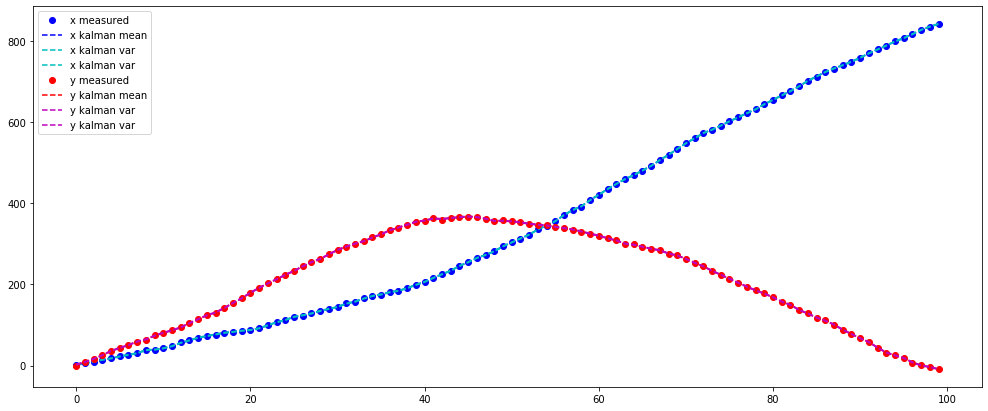

In [248]:
times = range(len(measurements))
kalman_variances = np.array(list(map(lambda x: [x[0][0], x[1][1], x[2][2], x[3][3]], posterior_covariances)))
plt.plot(times, measurements[:, 0], 'bo', label='x measured')
plt.plot(times, np.array(posterior_state_means)[:, 0], 'b--', label='x kalman mean')
plt.plot(times, np.array(posterior_state_means)[:, 0] + kalman_variances[:, 0], 'c--', label='x kalman var')
plt.plot(times, np.array(posterior_state_means)[:, 0] - kalman_variances[:, 0], 'c--', label='x kalman var')


plt.plot(times, measurements[:, 1], 'ro', label='y measured')
plt.plot(times, np.array(posterior_state_means)[:, 1], 'r--', label='y kalman mean')
plt.plot(times, np.array(posterior_state_means)[:, 1] + kalman_variances[:, 1], 'm--', label='y kalman var')
plt.plot(times, np.array(posterior_state_means)[:, 1] - kalman_variances[:, 1], 'm--', label='y kalman var')

plt.legend()

print("LOGLIKELIHOOD: ", loglikelihood)

# An attempt at creating a Particle Filter

In [339]:
import numpy as np
import scipy
import math
from matplotlib.patches import Ellipse

class ParticleFilter:
    def __init__(self, N, ranges, F, H, Q, R, resampling_algo, x_0=None):
        assert len(F) == len(F[0]), "F has to be a square matrix"
        assert len(Q) == len(Q[0]), "Q has to be a square matrix"
        assert len(R) == len(R[0]), "R has to be a square matrix"
        
        assert len(F) == len(ranges), "dimensions are not equal"
        assert len(F) == len(Q), ""
        assert len(H) == len(R), ""
        
        self.N = N
        self.ranges = ranges
        self.weights = np.ones(N) / N
        
        if not x_0:
            self.particles = self.uniform_particles(ranges, N)
        else:
            self.particles = self.normal_particles(ranges, N, x_0)
        
        self.F = F
        self.H = H
        self.Q = Q
        self.R = R
        
        self.resampling_algo = resampling_algo
        
        self.last_z = [0] * len(R) # plotting purposes
        

    def uniform_particles(self, ranges, N):
        # Returns list of uniform particles
        particles = np.empty((N, len(ranges)))
        for i, (start, end) in enumerate(ranges):
            particles[:, i] = np.random.uniform(low=start, high=end, size=N)
        return particles
    
    def normal_particles(self, ranges, N, x_0):
        particles = np.empty((N, len(ranges)))
        for i, (start, end) in enumerate(ranges):
            particles[:, i] = np.random.normal(loc=x_0[i], scale=(end-start)/10, size=N)
        return particles
    
    def predict(self):
        # step :: particles -> new_particles
        step_noise = lambda : np.random.multivariate_normal(mean=np.zeros(len(Q)), cov=self.Q)
        self.particles = np.array([np.matmul(self.F, particle) + step_noise() for particle in self.particles])
    
    def update(self, z): 
        # z is the noisy measurement
        self.last_z = z
        
        measurement_noise = lambda : np.random.multivariate_normal(mean=np.zeros(len(R)), cov=self.R)
        observations = np.array([np.matmul(self.H, particle) + measurement_noise() for particle in self.particles])
        
        self.weights *= scipy.stats.multivariate_normal.pdf(x=observations, mean=z, cov=self.R)        
        self.weights += 1.e-100 # avoid round off to zero
        self.weights /= np.sum(self.weights) # normalize
    
    def estimate(self):
        # evaluate :: particle -> result
        observations = np.array([np.matmul(self.H, particle) for particle in self.particles])
        mean = np.average(observations, weights=self.weights, axis=0)
        var = np.sqrt(np.average((observations - mean)**2, weights=self.weights, axis=0))
        return mean, var
    
    def resample(self):
        self.particles, self.weights = self.resampling_algo(self.particles, self.weights)
    
    def neff(self):
        return 1. / np.sum(np.square(self.weights))
    
    def plot2D(self):
        plt.scatter(x=self.particles[:, 0], y=self.particles[:, 1], c='b', label='particles')
        
        mean, var = self.estimate()
        plt.scatter(x=mean[0], y=mean[1], s=80, facecolors='none', edgecolors='b', label='pf estimation')
        
        plt.scatter(x=self.last_z[0], y=self.last_z[1], s=80, facecolors='none', edgecolors='g', label='last measurement')

        plt.xlim(self.ranges[0])
        plt.ylim(self.ranges[1])
        
        
        e = Ellipse(xy=mean, height=var[1], width=var[0])
        ax = plt.gca() 
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_edgecolor("red")
        e.set_facecolor("none")
        e.set_alpha(1)
        plt.title("Ellipse = pf variance")
        plt.legend()
        
    def run(self, measurements):
        likelihood = 1
        
        #initial mean and variance
        print(self.N, "particles ",end="")
        initial_mean, initial_variance = self.estimate()
        means = [initial_mean]
        variances = [initial_variance]
        for i, z in enumerate(measurements):
            self.predict()
            self.update(z)
            
            mean, var = self.estimate()
            means.append(mean)
            variances.append(var)
            
            p_ykxk = lambda i: scipy.stats.multivariate_normal.pdf(z, mean=H@self.particles[i], cov=self.R) # p(yk|xki)
            Pyk = np.sum([p_ykxk(i) * self.weights[i] for i in range(self.N)]) # Phat(y_k|y_0:k-1)
            likelihood *= Pyk
            
            
            if self.neff() < len(self.particles)/2:
                print("R", end="")
                self.resample()
            else:
                print(".", end="")
        print(" end")
        print("MARGINAL LIKELIHOOD: ", likelihood)
        return np.array(means), np.array(variances)        
        

# A simple resampling algorithm

In [340]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.uniform(0, 1, N))
    
    return particles[indexes], np.ones(N)/N

In [341]:
pf = ParticleFilter(
    N=100, 
    ranges=[(-100, 200), (-100, 400), (0, 2*np.pi), (0, 2*np.pi)],
    F=F,
    H=H,
    Q=Q,
    R=R,
    resampling_algo=simple_resample
)

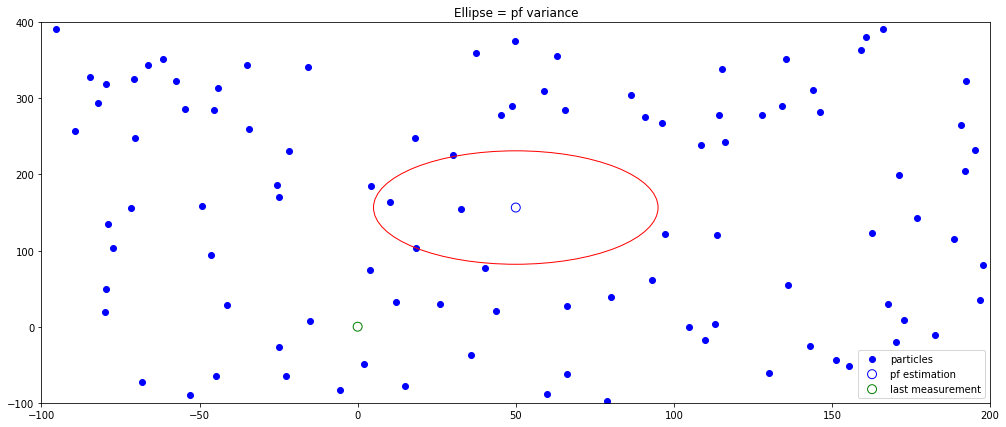

In [342]:
pf.plot2D()

# Particle filter with 10000 particles

1000 particles RRRRR...........................RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR end
MARGINAL LIKELIHOOD:  0.0


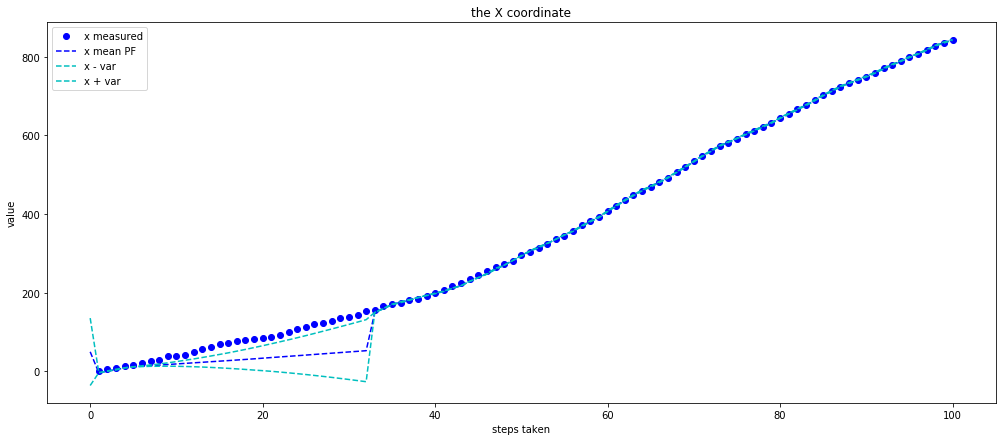

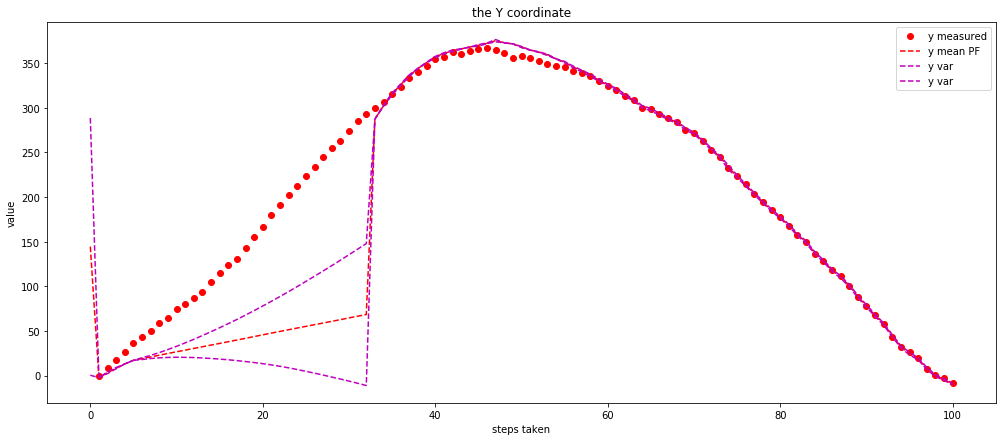

In [343]:
pf = ParticleFilter(
    N=1000, 
    ranges=[(-100, 200), (-100, 400), (0, 2*np.pi), (0, 2*np.pi)],
    F=F,
    H=H,
    Q=Q,
    R=R,
    resampling_algo=simple_resample
)

means10000, variances10000 = pf.run(measurements)

plt.figure(1)
times = range(measurements.shape[0] + 1)
plt.plot(times[1:], measurements[:, 0], 'bo', label='x measured')
plt.plot(times, means10000[:, 0], 'b--', label='x mean PF')
plt.plot(times, means10000[:, 0] - variances10000[:, 0], 'c--', label='x - var')
plt.plot(times, means10000[:, 0] + variances10000[:, 0], 'c--', label='x + var')
plt.xlabel("steps taken")
plt.ylabel("value")
plt.title("the X coordinate")
plt.legend()

plt.figure(2)
plt.plot(times[1:], measurements[:, 1], 'ro', label='y measured')
plt.plot(times, means10000[:, 1], 'r--', label='y mean PF')
plt.plot(times, means10000[:, 1] - variances10000[:, 1], 'm--', label='y var')
plt.plot(times, means10000[:, 1] + variances10000[:, 1], 'm--', label='y var')
plt.xlabel("steps taken")
plt.ylabel("value")
plt.title("the Y coordinate")
plt.legend()

..RRRRRRRR..........................................................................................end
....RRRRRRRRRRRRR...............................RR..................................................end
RRRRRRRRRRRRR.......RRRRRRRRRRRRRRRRRRRR............................................................end
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend


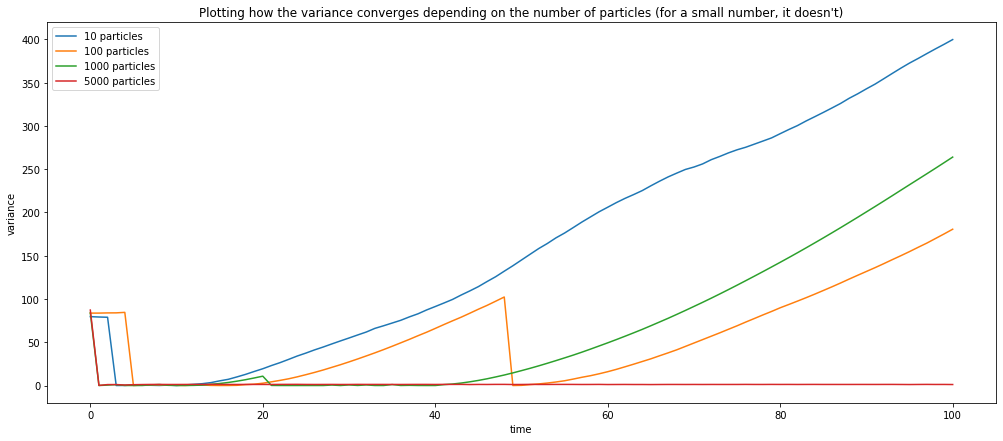

In [262]:
nr_of_particles_to_test = [10, 100, 1000, 5000]
means = {}
variances = {}

for nr in nr_of_particles_to_test:
    pf = ParticleFilter(
        N=nr, 
        ranges=[(-100, 200), (-100, 400), (0, 2*np.pi), (0, 2*np.pi)],
        F=F,
        H=H,
        Q=Q,
        R=R,
        resampling_algo=simple_resample
    )
    means[nr], variances[nr] = pf.run(measurements)

plt.figure(1)
times = range(measurements.shape[0] + 1)

for nr in nr_of_particles_to_test:
    plt.plot(times, variances[nr][:, 0], label=str(nr)+" particles")
    
    
# plt.plot(times, variances[:, 1], label='y var')
plt.xlabel("time")
plt.ylabel("variance")
plt.title("Plotting how the variance converges depending on the number of particles (for a small number, it doesn't)")
plt.legend()

RRRR..........RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend
RRRRRRRRRRRRRRRRR...................RRRRR...........................................................end
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend
RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRend
RRRRRR..........RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR

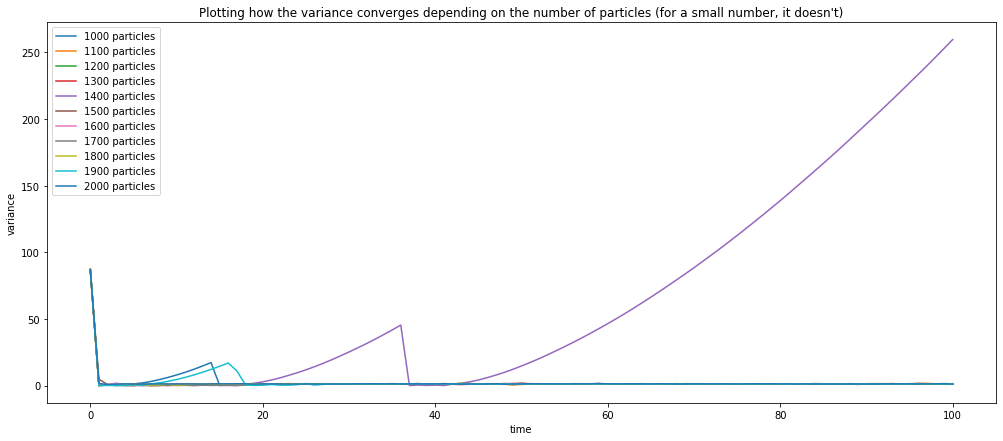

In [294]:
nr_of_particles_to_test = [1000 + 100 * x for x in range(11)]
means = {}
variances = {}

from multiprocessing import Pool

def test(x):
    pf = ParticleFilter(
        N=x, 
        ranges=[(-100, 200), (-100, 400), (0, 2*np.pi), (0, 2*np.pi)],
        F=F,
        H=H,
        Q=Q,
        R=R,
        resampling_algo=simple_resample
    )
    return pf.run(measurements)

with Pool(10) as pool:
    res = np.array(pool.map(test, nr_of_particles_to_test))

plt.figure(1)
times = range(measurements.shape[0] + 1)
for nr in range(len(nr_of_particles_to_test)):
    plt.plot(times, res[nr][1][:, 0], label=str(nr_of_particles_to_test[nr])+" particles")
    
# plt.plot(times, variances[:, 1], label='y var')
plt.xlabel("time")
plt.ylabel("variance")
plt.title("Plotting how the variance converges depending on the number of particles")
plt.legend()

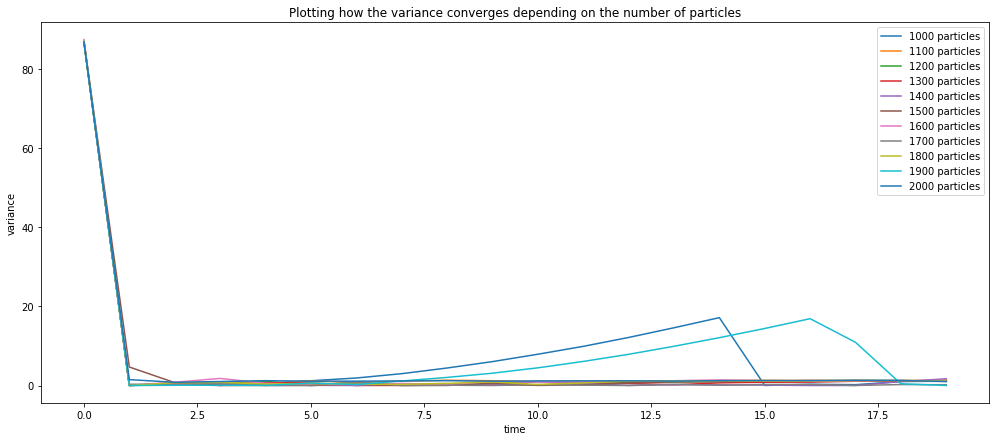

In [296]:
plt.figure(1)
times = range(20)
for nr in range(len(nr_of_particles_to_test)):
    plt.plot(times, res[nr][1][:20, 0], label=str(nr_of_particles_to_test[nr])+" particles")
    
# plt.plot(times, variances[:, 1], label='y var')
plt.xlabel("time")
plt.ylabel("variance")
plt.title("Plotting how the variance converges depending on the number of particles")
plt.legend()